# Krypton RPHI corrections

## Correct energy using fine-grained XY map then correct lifetime in bins of RPHI and time

### Author:  JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Sun Oct 14 23:22:17 2018


### Logger

In [2]:
import logging


logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')


2018-10-14 23:22:18,356 | INFO : Hello world!


### Input files

In [93]:
from krcal.core.kr_types import KrFileName
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

#input_file_names  = ['dst_6347_trigger1_0000_9672.h5',
#                     'dst_6348_trigger1_0000_9488.h5',
#                     'dst_6349_trigger1_0000_9562.h5',
#                    'dst_6350_trigger1_0000_9564.h5',
#                     'dst_6351_trigger1_0000_9580.h5',
#                    'dst_6352_trigger1_0000_9838.h5',
#                     'dst_6353_trigger1_0000_9453.h5']

input_file_names  = ['dst_6349_trigger1_0000_9562.h5',
                     'dst_6350_trigger1_0000_9564.h5',
                     'dst_6351_trigger1_0000_9580.h5',
                     'dst_6352_trigger1_0000_9838.h5',
                     'dst_6353_trigger1_0000_9453.h5']
RMAX      = 200
SR        = 20
SPHI      = 36
time_bins = 25
r_bins    = int(RMAX / SR)
phi_bins  = int(360 / SPHI)

print(f'r bins = {r_bins}; phi=bins={phi_bins}')
output_file_name  = ' '
map_file_name     = 'kr_maps_xy_6350_6353.h5'
map_file_name_ts  = f'kr_maps_rphi_{r_bins}_{phi_bins}_ts_{time_bins}_6350_6353.h5'
emap_file_name    = 'kr_emap_xy_6349_6353.h5'


krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

r bins = 10; phi=bins=10


### Notebook configuration

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts

In [8]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [9]:
from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import NN
from krcal.core                     import fit_functions_ic as fitf

In [10]:
from krcal.core.plt_functions  import plot_sector
from krcal.core.plt_functions  import plot_sectors

In [11]:
from krcal.core.stat_functions      import mean_and_std

In [12]:
from krcal.core.analysis_functions  import kr_ranges_and_bins
from krcal.core.analysis_functions  import fiducial_volumes
from krcal.core.analysis_functions  import fid_eff
from krcal.core.analysis_functions  import select_rphi_sectors
from krcal.core.analysis_functions  import select_xy_sectors
from krcal.core.analysis_functions  import event_map

from krcal.core.analysis_functions  import kr_event_selection
from krcal.core.analysis_functions  import kr_event

In [13]:
from krcal.core.fit_lt_functions    import fit_lifetime
from krcal.core.fit_lt_functions    import time_fcs
from krcal.core.fit_lt_functions    import fit_fcs_in_rphi_sectors
from krcal.core.fit_lt_functions    import fit_fcs_in_xy_bin
from krcal.core.fit_lt_functions    import fit_map_rphi
from krcal.core.fit_lt_functions    import fit_map_xy
from krcal.core.fit_lt_functions    import get_time_series

In [14]:
from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy
from krcal.core.fit_lt_histograms   import plot_time_fcs
from krcal.core.fit_lt_histograms   import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_histograms   import print_fit_lifetime

In [15]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

In [16]:
from krcal.core.kr_types import PlotLabels, KrEvent, ASectorMap
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName


In [17]:
from krcal.core.rphi_maps_functions   import draw_rphi_maps
from krcal.core.rphi_maps_functions   import draw_rphi_map
from krcal.core.rphi_maps_functions   import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions   import draw_wedges
from krcal.core.rphi_maps_functions   import define_rphi_sectors
from krcal.core.rphi_maps_functions   import rphi_sector_alpha_map
from krcal.core.rphi_maps_functions   import rphi_sector_map_def

In [18]:
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average

In [19]:
from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.xy_maps_functions   import draw_xy_map
from krcal.core.xy_maps_functions   import draw_xy_maps_ts

In [20]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [21]:
from krcal.core.correction_functions import e0_rphi_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_rphi_correction
from krcal.core.correction_functions import lt_rphi_correction_ts
from krcal.core.correction_functions import e0_rphi_correction_ts

In [22]:
import krcal.dev.corrections       as corrections 


In [23]:
from numpy import pi, sqrt

In [24]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [25]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Logger


- CRITICAL
- ERROR
- WARNING
- INFO
- DEBUG



In [26]:
log = logging.getLogger()

### Input/output 

In [94]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [95]:
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6349_trigger1_0000_9562.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6350_trigger1_0000_9564.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6351_trigger1_0000_9580.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6352_trigger1_0000_9838.h5', '/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6353_trigger1_0000_9453.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ ', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_xy_6350_6353.h5', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_rphi_10_10_ts_25_6350_6353.h5', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_6349_6353.h5')

In [29]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [30]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {len(dst)}")

Total number of events: 4918954


In [31]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [32]:
RMAX      = 200
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 6000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [33]:
dst = dst[in_range(dst.R, 0, RMAX)]

In [34]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

In [35]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

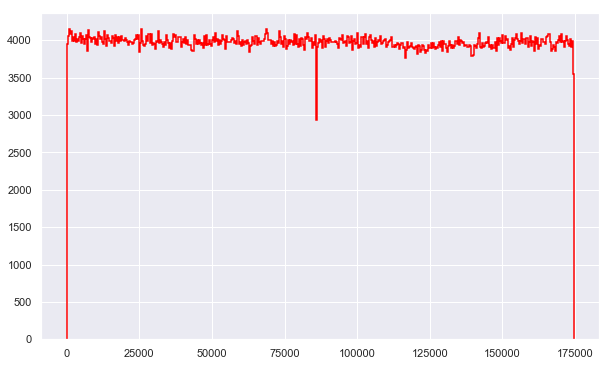

In [36]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

### Time 

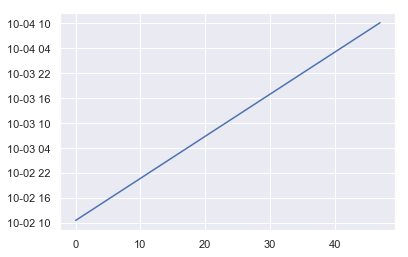

In [37]:
plt.plot(krTimes.timeStamps)

### Event distribution

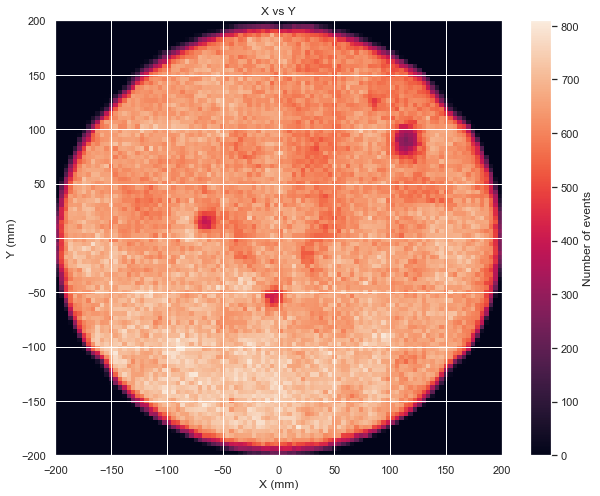

In [38]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

## Time series

In [35]:
log.setLevel(logging.INFO)

### Divide dst in time series

In [39]:

t0 = time.time()
ts, masks = get_time_series(time_bins, DT[-1], kge)  
t1 = time.time()
print(f' get_time_series: t = {t1 -t0}')

 get_time_series: t = 0.22925209999084473


### Fit lifetime full detector

In [40]:
t0 = time.time()
fps = time_fcs(ts, masks, kge, 
               nbins_z = 15,
               nbins_e = 25,
               range_z = (10, 550),
               range_e = (7000, 14000),
               energy  = 'S2e',
               fit     = FitType.profile)
t1 = time.time()
print(f' time_fcs: t = {t1 -t0}')

 time_fcs: t = 1.232861042022705


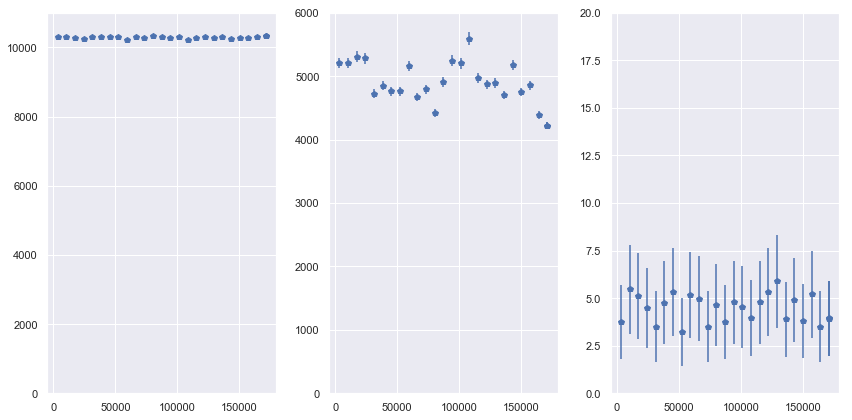

In [49]:
plot_time_fcs(fps,
              range_chi2  = (0,20),
              range_e0    = (0,11000),
              range_lt    = (0, 6000),
              figsize     = (12,6))

## Lifetime in RPhi

In [42]:
NSECTORS =int(r_bins)  # number of sectors in R. Each sector then is 200 / 5 = 40 cm.

In [43]:
rpsmd = rphi_sector_map_def(nSectors=NSECTORS, rmax=RMAX, sphi=SPHI)

In [44]:
W = define_rphi_sectors(rpsmd)

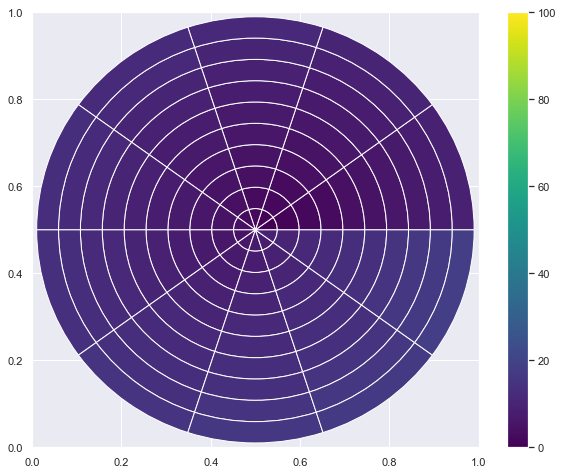

In [45]:
draw_wedges(W,  rmax = RMAX, 
            scale= 0.49, figsize=(10,8), alpha=1.0,
            cr =range(NSECTORS))

In [46]:
t0 = time.time()
KSRP = select_rphi_sectors(dst, DT, dst.S2e, dst.S2q, W)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 KRES: t = 11.913197994232178


In [47]:
neM = event_map(KSRP)

In [48]:
neM

,0,1,2,3,4,5,6,7,8,9
0,5026,14329,25704,37112,47550,57834,69000,81540,91956,84085
1,5084,15075,27583,37459,47631,60292,73677,85084,95528,79947
2,5192,15223,22896,36206,48892,61756,74317,85216,95619,75400
3,5209,15184,25672,36112,46277,59776,72265,80507,89665,77916
4,5181,13727,26040,36384,47397,57071,67085,79756,89302,79610
5,5153,14512,23017,35008,46053,54048,62899,72244,87541,76563
6,5074,15392,23584,32873,42826,54184,62877,66054,80261,60457
7,5183,15180,25738,34841,44413,54709,64268,73943,83934,60101
8,5252,15366,24917,35147,44335,56269,67631,78361,86767,57940
9,5189,14251,23978,31857,46679,54180,63384,76042,88796,75530


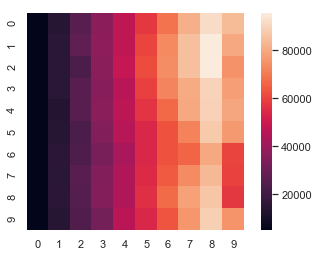

In [50]:
ax = sns.heatmap(neM, square=True)

### four phi sectors: upper half (left-right), lower half (left-right) of chamber

### R < 40 mm

In [54]:
erange = (0,13000)
ltrange = (0, 6000)

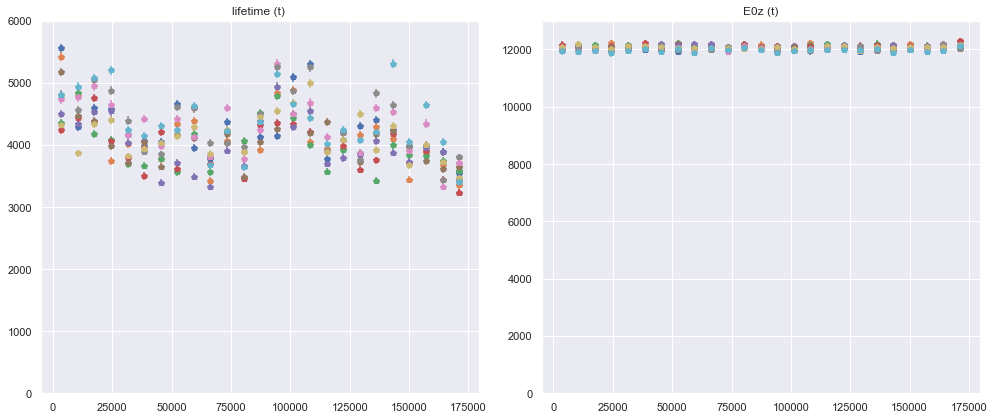

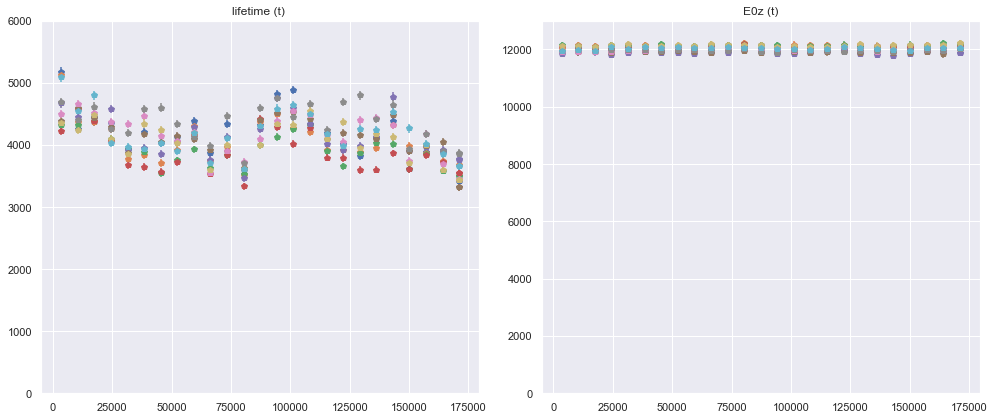

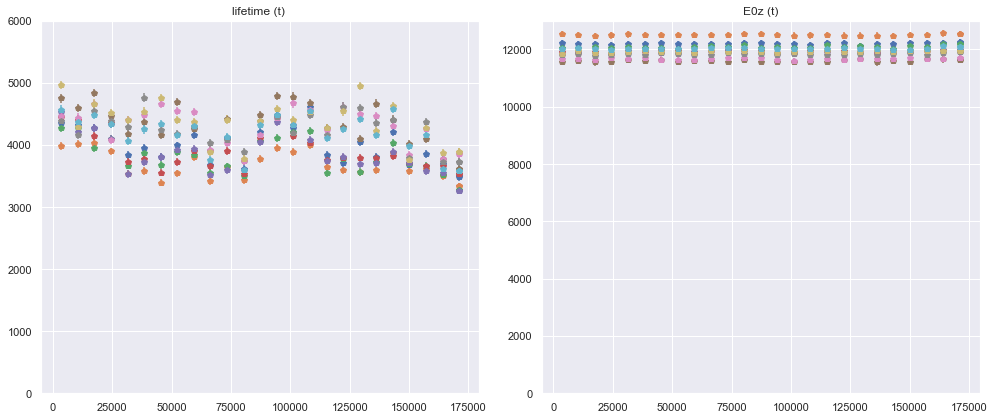

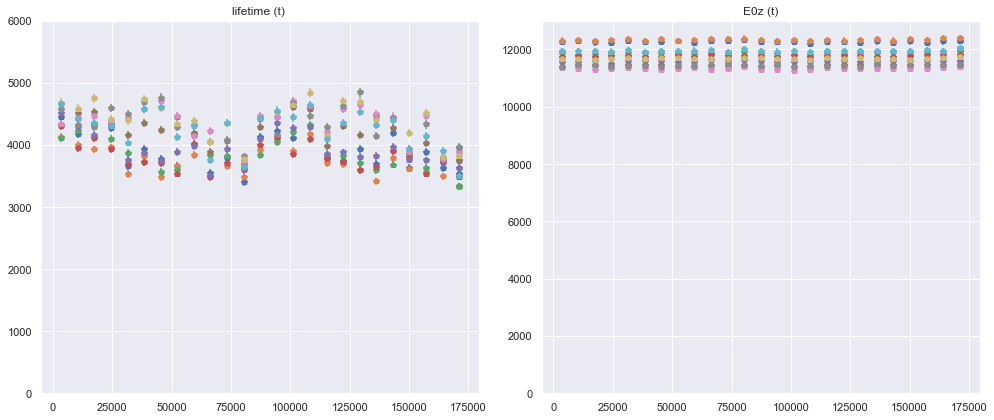

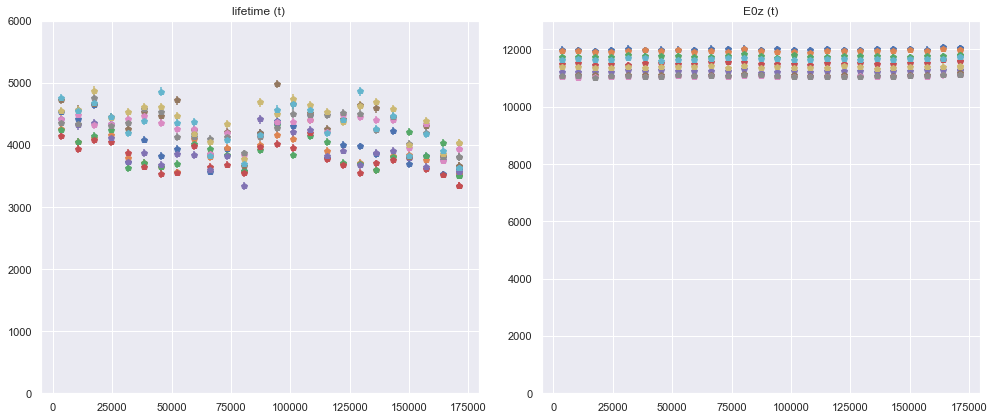

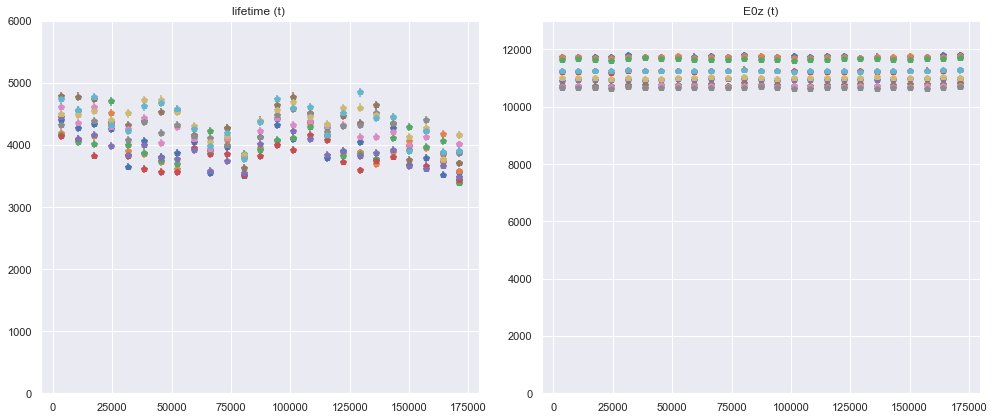

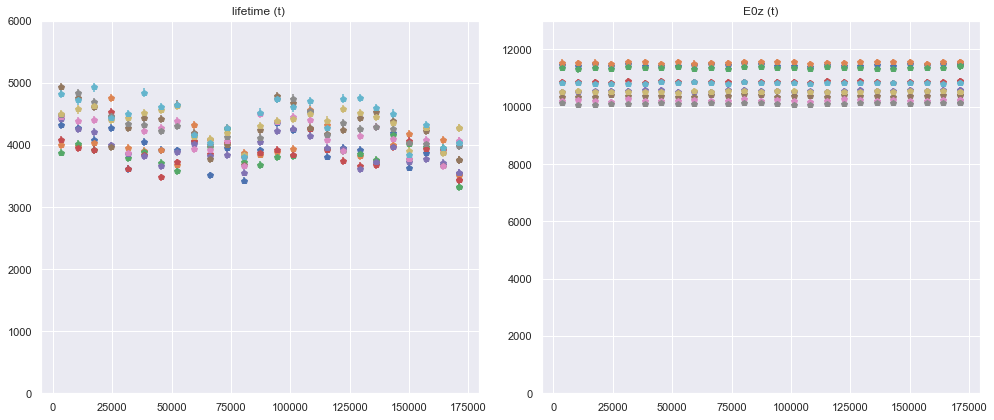

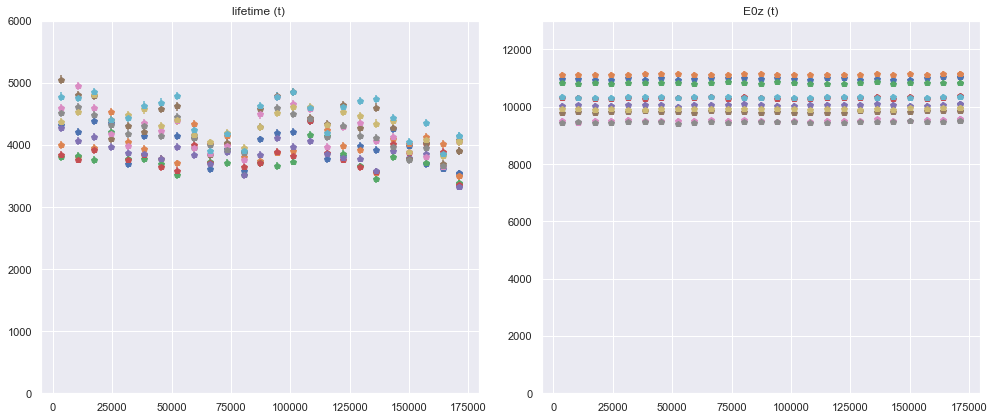

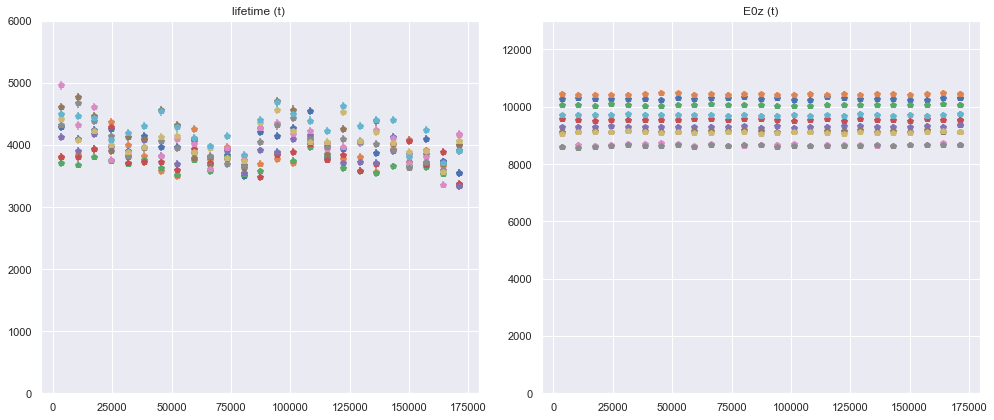

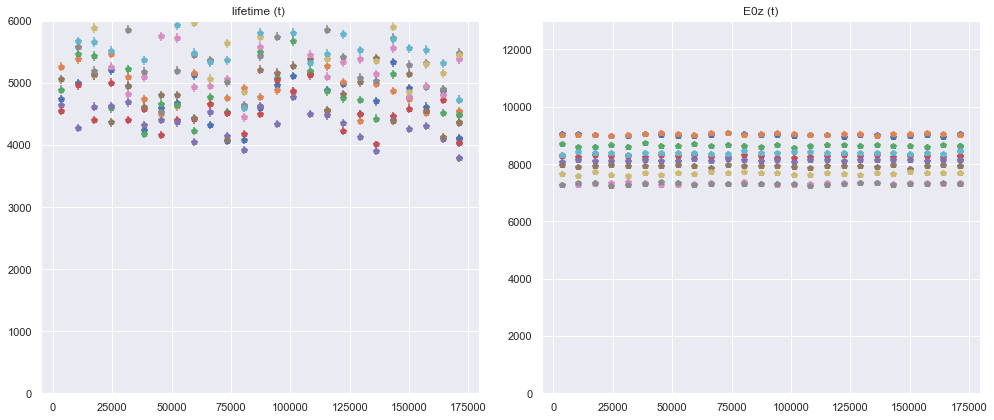

In [56]:
for ns in range(NSECTORS):
    fps = fit_fcs_in_rphi_sectors(sector = ns,
                              selection_map = KSRP,
                              event_map     = neM,
                              n_time_bins   = time_bins,
                              time_diffs    = DT,
                              nbins_z       = 25,
                              nbins_e       = 50,
                              range_z       =(50, 550),
                              range_e       = (5000, 13500),
                              energy        = 'S2e',
                              fit           = FitType.unbined,
                              n_min         = 100)
    plot_fit_sectors(fps,  range_e0 =erange, range_lt=ltrange)

### Lifetime patterns:

- Oscillatory pattern in time with a swing of 1 ms!
- Lifetime changes also as a function of Phi, with differences that increase as R increases.
- R > 160 cm data shows very high and very variable lifetime, with a spread of several ms.

### Strategy

- Try to correct geometrical effects first. Fine grained geometrical map with a single time bin.
- Study time dependence later

### Read XY MAPS

In [57]:
emaps = read_maps(filename=fn.emap_file_name)

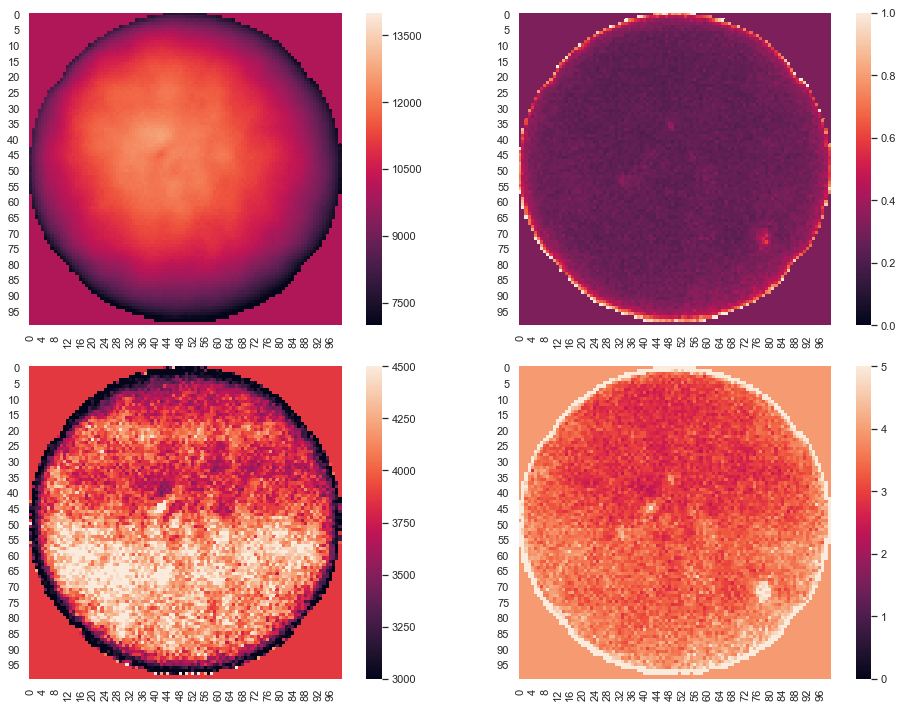

In [58]:
draw_xy_maps(emaps,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 4500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [59]:
amap_average(emaps)

ASectorMap(chi2=1.3103272509161852, e0=10244.758611036903, lt=3915.3163657558634, e0u=0.3070319499640985, ltu=3.7637620092708524)

In [60]:
norm = amap_max(emaps)

In [61]:
norm

ASectorMap(chi2=2370.7295827806597, e0=12698.695616298823, lt=5592.29036706649, e0u=1.6600319256306426, ltu=45.5411986298094)

In [62]:
t0 = time.time()
E0 = e0_xy_correction(dst.S2e.values,
                      dst.X.values,
                      dst.Y.values,
                      E0M = emaps.e0 / norm.e0, 
                      xr  = krRanges.X,
                      yr  = krRanges.Y,
                      nx  = krNbins.X, 
                      ny  = krNbins.Y)


t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 42.37202310562134


### Select sectors with corrected energy

In [65]:
t0 = time.time()
KRP = select_rphi_sectors(dst, DT, E0, dst.S2q, W)
t1 = time.time()
print(f' KRP: t = {t1 -t0}')

 KRP: t = 12.18792176246643


In [66]:
neM = event_map(KRP)

In [67]:
neM

,0,1,2,3,4,5,6,7,8,9
0,5026,14329,25704,37112,47550,57834,69000,81540,91956,84085
1,5084,15075,27583,37459,47631,60292,73677,85084,95528,79947
2,5192,15223,22896,36206,48892,61756,74317,85216,95619,75400
3,5209,15184,25672,36112,46277,59776,72265,80507,89665,77916
4,5181,13727,26040,36384,47397,57071,67085,79756,89302,79610
5,5153,14512,23017,35008,46053,54048,62899,72244,87541,76563
6,5074,15392,23584,32873,42826,54184,62877,66054,80261,60457
7,5183,15180,25738,34841,44413,54709,64268,73943,83934,60101
8,5252,15366,24917,35147,44335,56269,67631,78361,86767,57940
9,5189,14251,23978,31857,46679,54180,63384,76042,88796,75530


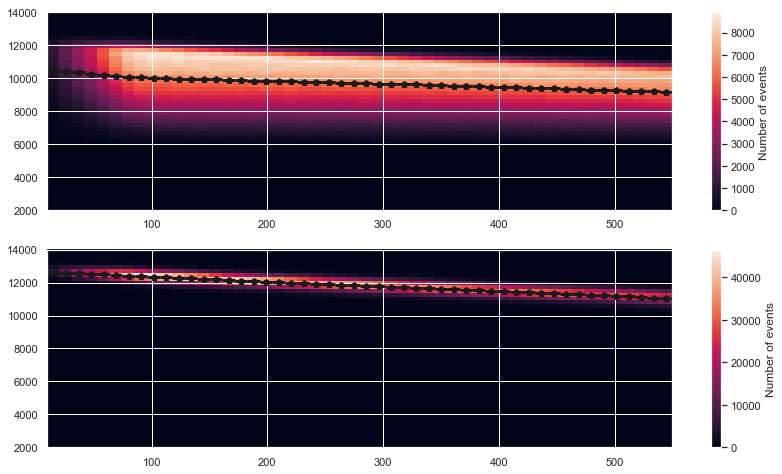

In [68]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

### Now compute maps in rphi.

In [73]:
t0 = time.time()
fmap = fit_map_rphi(selection_map    = KRP,
                       event_map     = neM,
                       n_time_bins   = time_bins,
                       time_diffs     = DT,
                       nbins_z        = krNbins.Z, 
                       nbins_e        = krNbins.S2e, 
                       range_z        = z_range, 
                       range_e        = e_range,
                       energy         = 'E',
                       fit            = FitType.unbined,
                       n_min          = 100)
t1 = time.time()
print(f' fmap: t = {t1 -t0}')

 fmap: t = 8.155418872833252


In [74]:
tsm = tsmap_from_fmap(fmap)

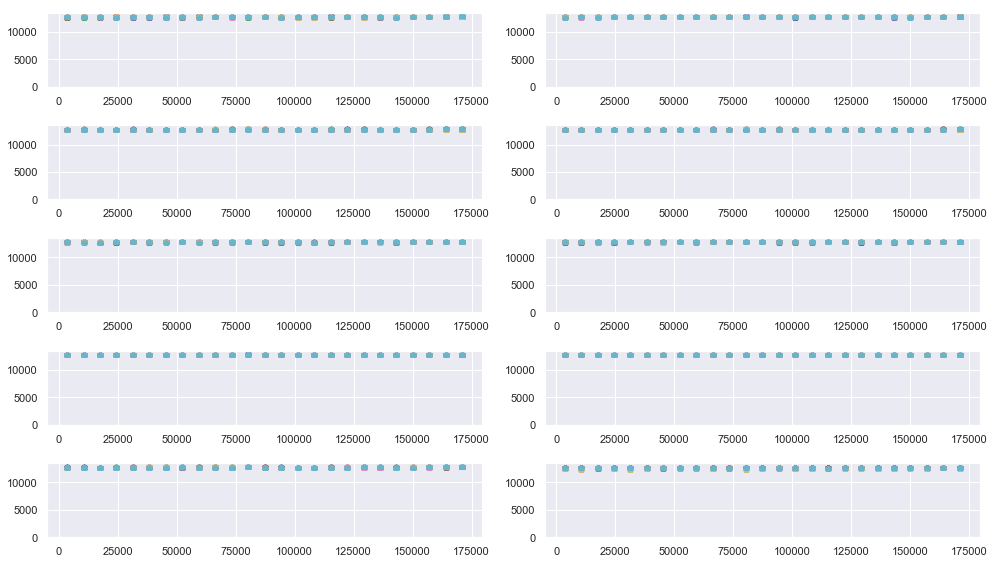

In [76]:
erange=(0, 13500)
fig = plt.figure(figsize=(14,8))
ix = 5
iy = 2
for j in range(0,NSECTORS):
    ax      = fig.add_subplot(ix, iy, j+1)
    plt.ylim(erange)
    for i in neM.index:
        plt.errorbar(ts, tsm.e0[j][i], np.sqrt(tsm.e0[0][i]), fmt="p")
plt.tight_layout()

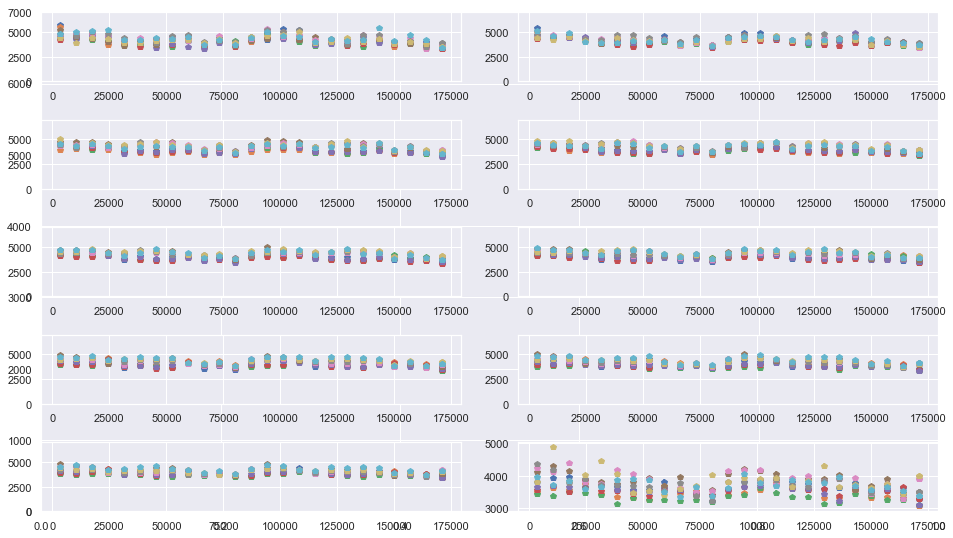

In [77]:
ltrange=(0, 7000)
fig = plt.figure(figsize=(14,8))
ix = 5
iy = 2
for j in range(0,NSECTORS):
    plt.ylim(ltrange)
    ax      = fig.add_subplot(ix, iy, j+1)
    for i in neM.index:
        plt.errorbar(ts, tsm.lt[j][i], np.sqrt(tsm.lt[0][i]), fmt="p")
plt.tight_layout()

In [78]:
amts0 = amap_from_tsmap(tsm, 
                     ts = 0, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)

In [79]:
avam = amap_average(amts0) 
avam

ASectorMap(chi2=0.9745296757625299, e0=12668.213008094908, lt=4406.646093678696, e0u=24.69013029382374, ltu=120.30552088974727)

In [80]:
asm0 = relative_errors(amts0)

In [81]:
amap_average(asm0) 

ASectorMap(chi2=0.9745296757625299, e0=12668.213008094908, lt=4406.646093678696, e0u=0.19505861163564062, ltu=2.664586174916762)

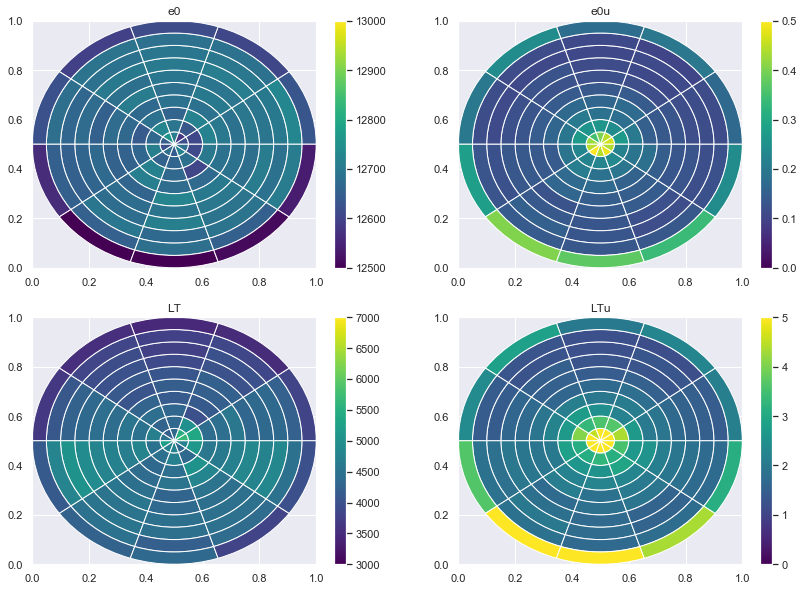

In [86]:
draw_rphi_maps(W, asm0,  
          e0lims  = (12500, 13000),
          ltlims  = (3000, 7000),
          eulims  = (0, 0.5),
          lulims  = (0,5),
          rmax=RMAX, 
          scale=0.5,
          alpha   = 1.0,  
          figsize=(14,10))

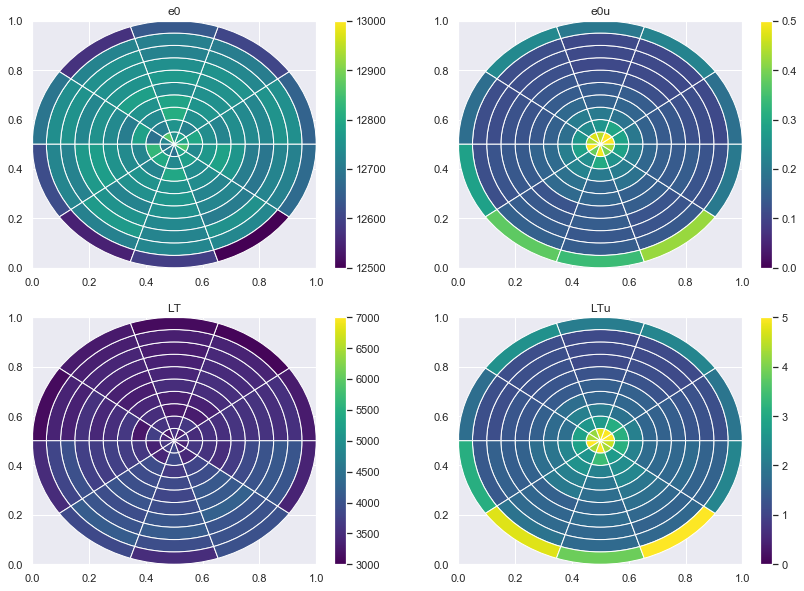

In [87]:
amts50 = amap_from_tsmap(tsm, 
                     ts = 25, 
                     range_e     = e_range,
                     range_chi2  = c2_range,
                     range_lt    = lt_range)
asm50 = relative_errors(amts50)
amap_average(asm50) 
draw_rphi_maps(W, asm50,  
          e0lims  = (12500, 13000),
          ltlims  = (3000, 7000),
          eulims  = (0, 0.5),
          lulims  = (0,5),
          rmax=RMAX, 
          scale=0.5,
          alpha   = 1.0,  
          figsize=(14,10))

### Maps for the full time series

In [89]:
aMaps = []
EE    = []
LT    = []
TT    = []
t0 = time.time()
for i, tt in enumerate(ts):
    am = amap_from_tsmap(tsm, 
                         ts = i, 
                         range_e     = (5000, 13000),
                         range_chi2  = (0,100),
                         range_lt    = (3000,7000))
    amv = amap_average(am) 
    asm = relative_errors(am)
    av = amap_replace_nan_by_mean(asm, amMean=amv)
    av0 = amap_average(av) 
    aMaps.append(av)
    EE.append(av0.e0)
    LT.append(av0.lt)
    TT.append(tt)
t1 = time.time()
print(f' t = {t1 -t0}')

 t = 0.16405200958251953


<ErrorbarContainer object of 3 artists>

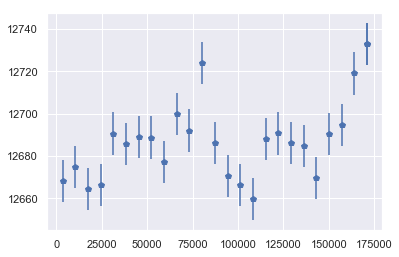

In [90]:
plt.errorbar(TT, EE, 10, fmt="p")

<ErrorbarContainer object of 3 artists>

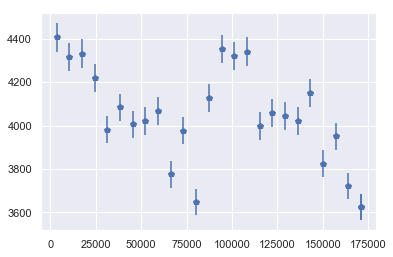

In [91]:
plt.errorbar(TT, LT, sqrt(LT), fmt="p")

### Write maps

In [96]:
fn.map_file_name_ts

'/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_rphi_10_10_ts_25_6350_6353.h5'

In [97]:
write_maps_ts(aMaps, ts, filename=fn.map_file_name_ts)

### Read maps

In [98]:
tts, tsMaps = read_maps_ts(fn.map_file_name_ts)

In [99]:
kdst = kr_event(dst, DT, E0, dst.S2q)
fr = RMAX / NSECTORS 

In [100]:
t0 = time.time()
kge =  e0_rphi_correction_ts(kdst, tts, tsMaps, fr, SPHI)     
t1 = time.time()
print(f' E0 correction: t = {t1 -t0}')

 E0 correction: t = 17.214600086212158


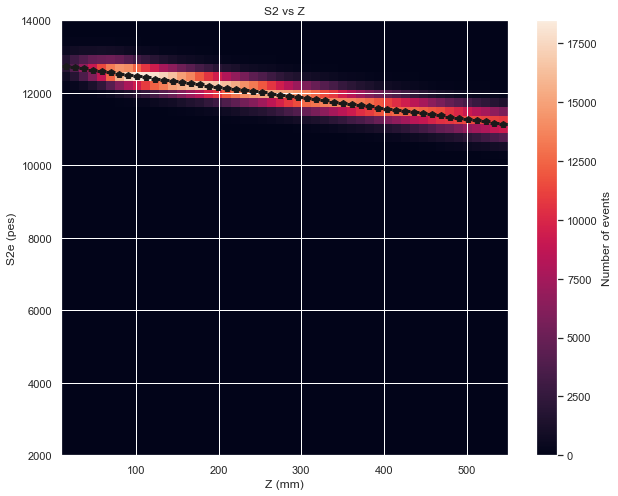

In [101]:
nevt = h2d(kge.Z, kge.E, 50, 50, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [102]:
t0 = time.time()
klt1 =  lt_rphi_correction_ts(kdst, tts, tsMaps, fr, SPHI)     
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

 LT correction: t = 17.182674884796143


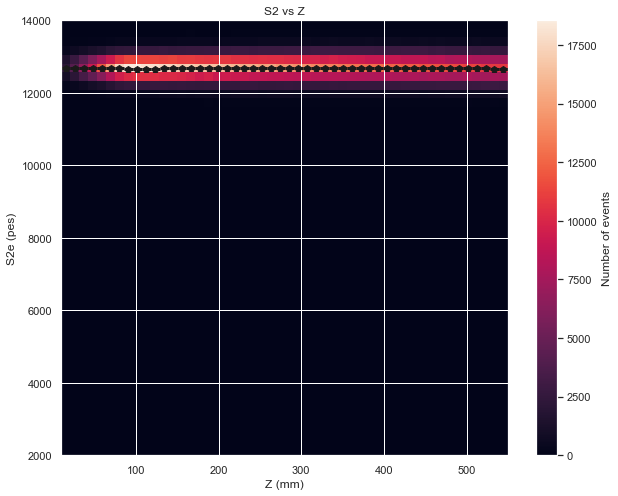

In [103]:
nevt = h2d(klt1.Z, klt1.E, 50, 50, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [104]:
t0 = time.time()
klt =  lt_rphi_correction_ts(kge, tts, tsMaps, fr, SPHI)     
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

 LT correction: t = 17.88777494430542


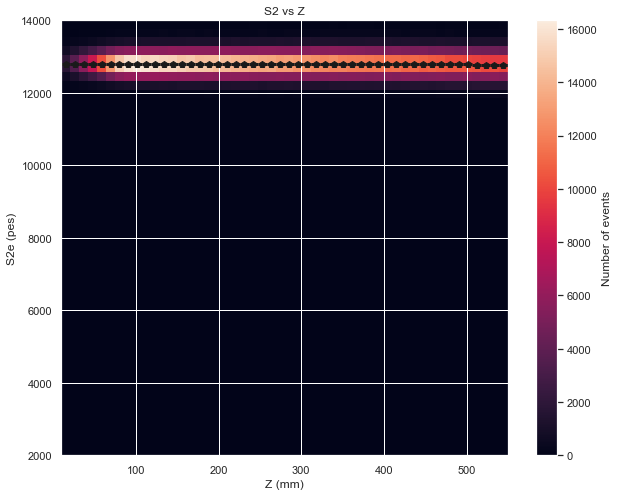

In [105]:
nevt = h2d(klt.Z, klt.E, 50, 50, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

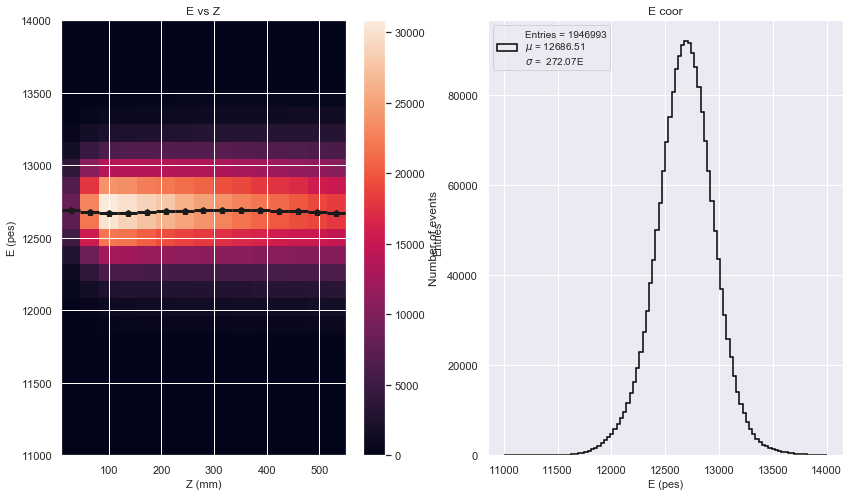

In [106]:
e_range = (11000, 14000)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(klt1.Z, klt1.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(klt1.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12688.45156698061 +-0.19065034212225834 
 E sigma   = 260.9037456296123 +-0.14922896717800824 
 chi2    = 9.735971335700325 
 sigma E/E (FWHM)     (%) =4.832140462474808
 sigma E/E (FWHM) Qbb (%) =0.6240803940579881 


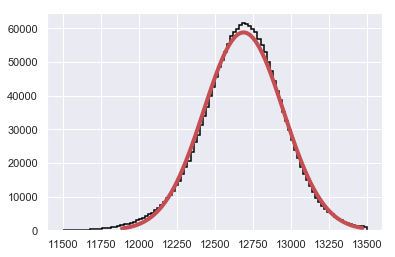

In [107]:
fc = fit_energy(klt1.E, nbins=100, range=(11500, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

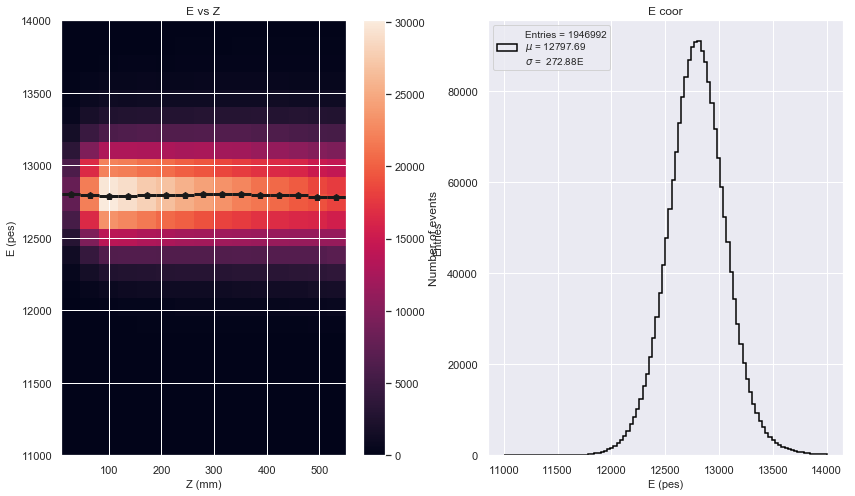

In [108]:
e_range = (11000, 14000)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(klt.Z, klt.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(klt.E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12794.756121502616 +-0.1936878177772317 
 E sigma   = 262.4518321288498 +-0.1539844316840213 
 chi2    = 6.802837023037263 
 sigma E/E (FWHM)     (%) =4.820426428185522
 sigma E/E (FWHM) Qbb (%) =0.6225675036128453 


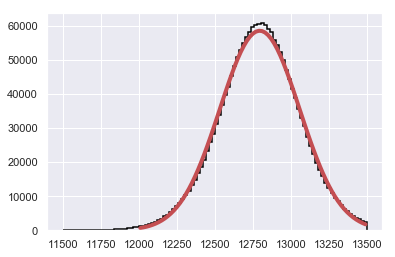

In [109]:
fc = fit_energy(klt.E, nbins=100, range=(11500, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

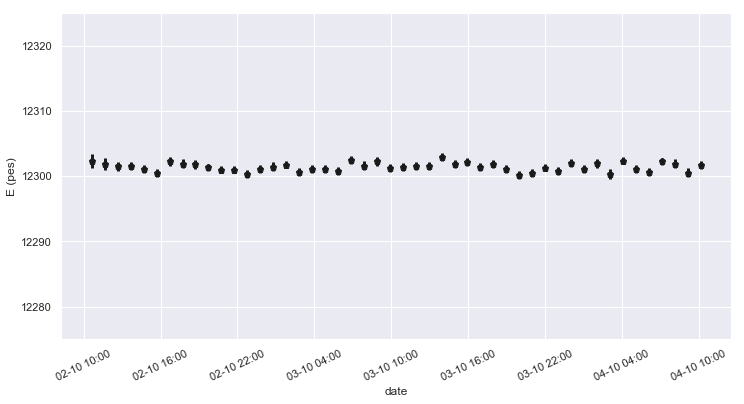

In [110]:
baseline = 12300
shift = 20
e1 = baseline - shift
e2 = baseline + shift
energy_time_profile(klt.T, klt.E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(12275, 12325),
                    figsize=(12,6))

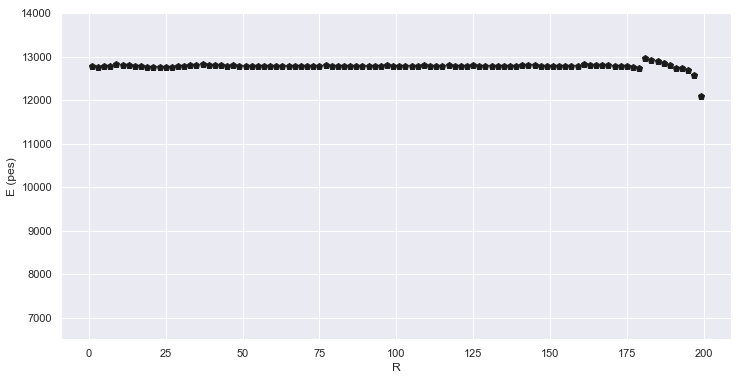

In [111]:
energy_X_profile(klt.R, klt.E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=(6500, 14000),  
                 figsize=(12,6))

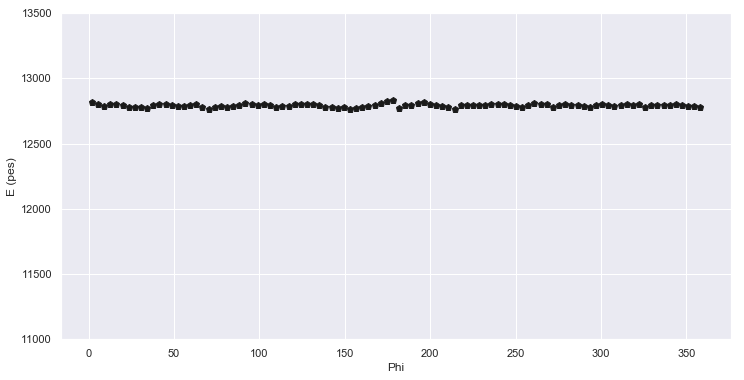

In [112]:
energy_X_profile(phirad_to_deg(klt.Phi), klt.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 13500),  
                 figsize=(12,6))

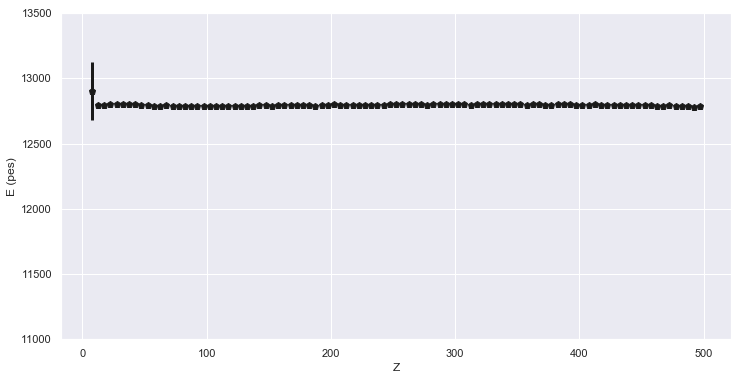

In [113]:
energy_X_profile(klt.Z, klt.E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(11000, 13500),   
                 figsize=(12,6))

(11000, 13500)

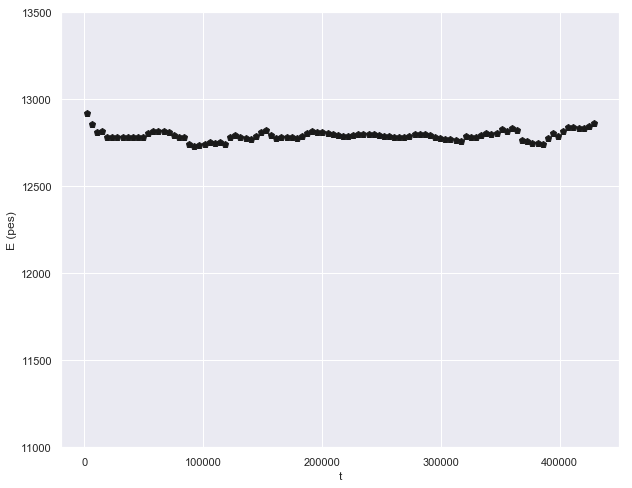

In [114]:
T   =(klt.T - klt.T.min()) 
t, e, eu = fitf.profileX(T, klt.E, 100)
erange =(11000, 13500)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E (pes)')
plt.ylim(erange)

In [115]:
e_mu    = np.nanmean(klt.E)
print(e_mu)
e_std   = np.nanstd (klt.E)
print(e_std)

12793.794169714281
303.3937874883773


In [116]:
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ek  = klt.E * ET_correction(T).value

(11000, 13500)

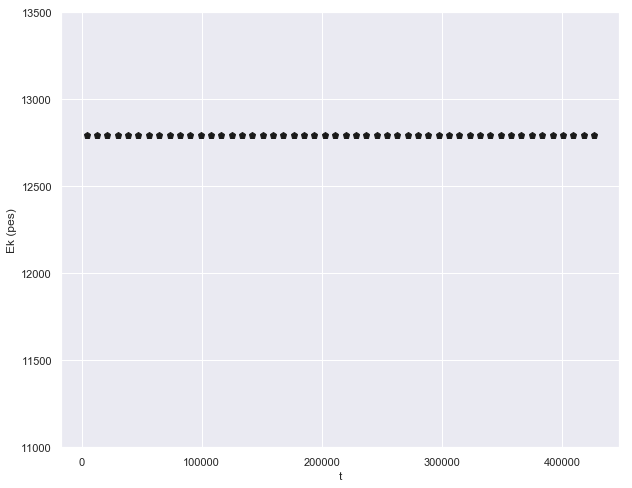

In [117]:
tc, ec, euc = fitf.profileX(T, Ek, 50)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('Ek (pes)')
plt.ylim(erange)

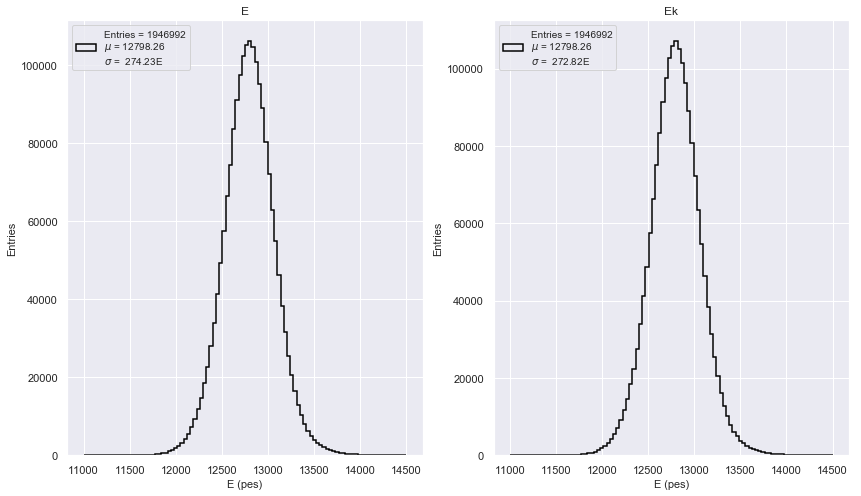

In [118]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

(_)     = h1(klt.E,  bins = 100, range =(11000,14500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ek,  bins = 100, range =(11000,14500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Ek'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12795.075554211435 +-0.1927649073729612 
 E sigma   = 260.842662273951 +-0.15381590029614647 
 chi2    = 8.399941211313923 
 sigma E/E (FWHM)     (%) =4.790751361698881
 sigma E/E (FWHM) Qbb (%) =0.618734910721455 


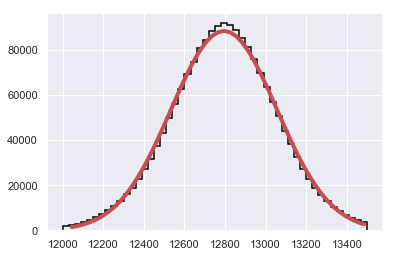

In [119]:
fc = fit_energy(Ek, nbins=50, range=(12000, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

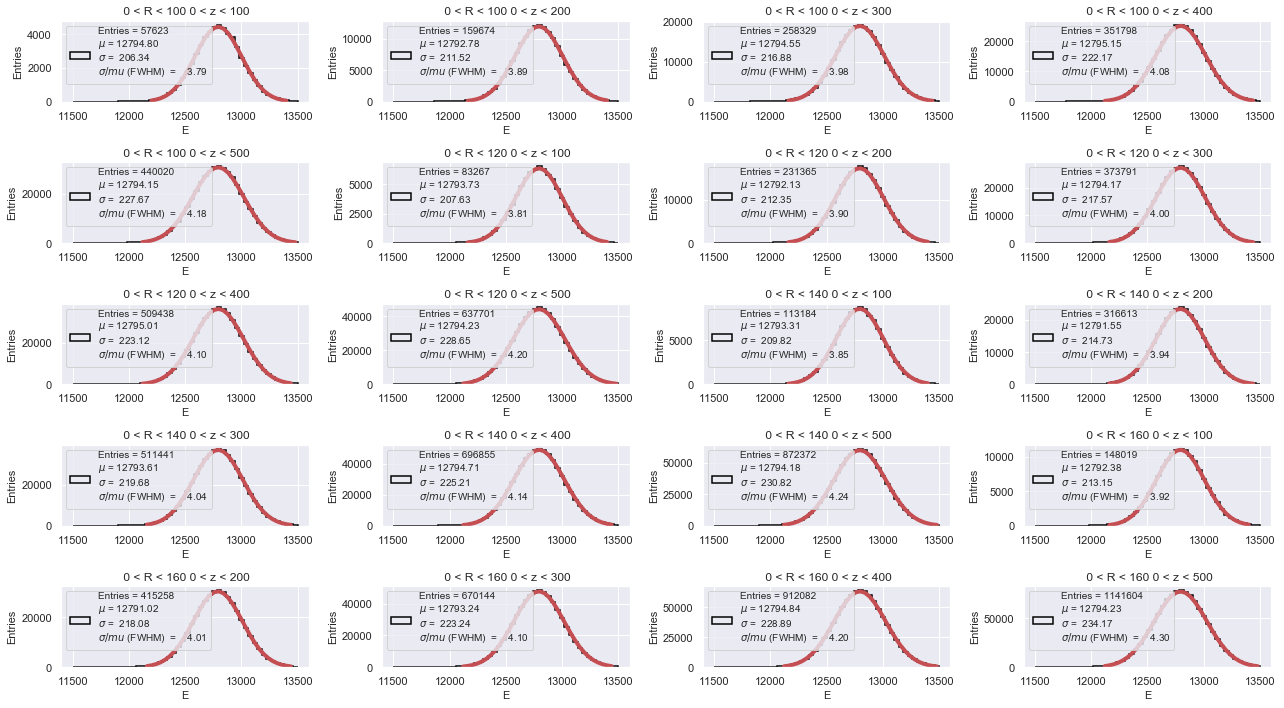

In [121]:
Ri = (100,120,140, 160)
Zi = (100,200,300,400,500)

FC, FCE = resolution_r_z(Ri, Zi, klt.R, klt.Z, Ek,
                    enbins = 50,
                    erange = (11500, 13500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10))                                

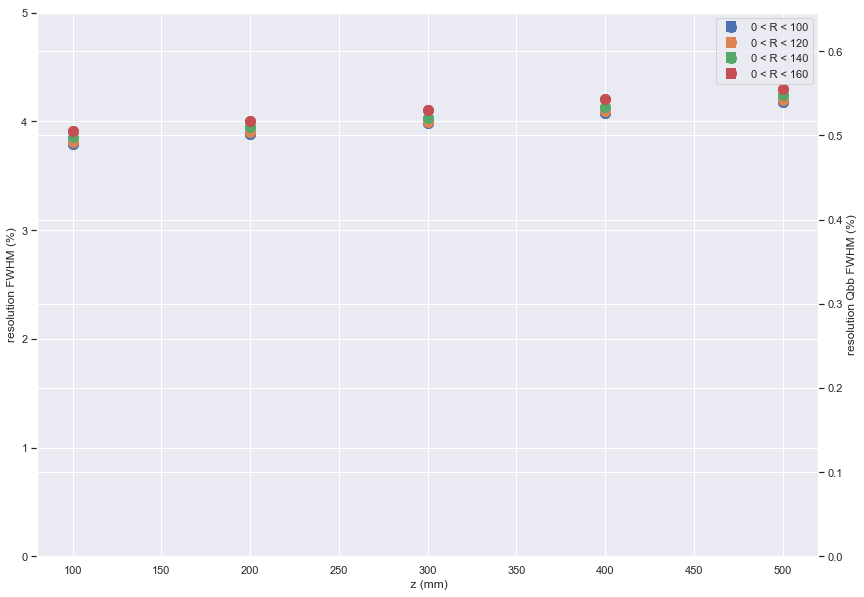

In [122]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range = (0, 5))